# Data Science Job Market EDA and Text Analysis
*By: <a href = 'https://www.linkedin.com/in/vidya-sagar-mekapothula-5382a8a1/'>M.Vidya Sagar</a>*

## Introduction

I'm currently a Jr.Facilitator (Data Science) at TEKS Academy. As my JNTUH AI-ML Certification course soon approaches, I've been actively looking for job in the analytics field. I wondered if there is a trend on what companies are looking for, what are the requirements, what can I do to make optimize my job search, so I set out to look for data on this subject.

Luckily for me, I came across this <a href = 'https://www.kaggle.com/sl6149/data-scientist-job-market-in-the-us'>Kaggle dataset</a> uploaded by ShaShan Lu. He scrapped 7000 job posting from indeed.com with the search term of "Data Science". Though the data is collected in 2018, I believe that the insights I get from analyzing this data will still be very beneficial for me to have.

I'll approach this data by performing EDA on the general dataset and text analysis on the job description. Any comments, recommendations and advice on this notebook would be much appreciated!

*Table of contents*

* <a href = '#DataPreparation'>Data Preparation</a>
    - <a href = '#cleaning'>Data Cleaning</a>
    - <a href = '#newclumn'>Populate New Columns</a>
    <br/><br/>
* <a href = '#eda'>Exploratory Data Analysis</a>
    - <a href = '#title'>Positions by Title</a>
    - <a href = '#company'>Positions by Company</a>
    - <a href = '#city'>Position by Cities</a>
    - <a href = '#state'>Position by State</a>
    - <a href = '#statetitle'>Position by State and Job Title</a>
    <br/><br/>
* <a href = '#textanalysis'>Text Analysis</a>
    - <a href = '#textclean'>Text Cleaning and Prep</a>
    - <a href = '#wordcloud'>Visualization</a>
        - <a href = '#wordcloud'>WordCloud</a>
        - <a href = '#experience'>Year of Experience Requirement</a>
        - <a href = '#skill'>Skills Requirement</a>
        - <a href = '#degree'>Degree Requirement</a>
    <br/><br/>
* <a href = '#conclution'>Conclusion</a>
    

In [3]:
import pandas as pd
import re
import string
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np

## Data Preparation<a id='DataPreparation'></a>

This data set contains 6953 rows with 5 columns: Position, Company, Job Description, Review, and Location.

In [4]:
# Load and view data
df = pd.read_csv('../input/data-scientist-job-market-in-the-us/alldata.csv',encoding="ISO-8859-1")
df.head()

,position,company,description,reviews,location
0,Development Director,ALS TDI,Development Director\nALS Therapy Development ...,NaN,"Atlanta, GA 30301"
1,An Ostentatiously-Excitable Principal Research...,The Hexagon Lavish,"Job Description\n\n""The road that leads to acc...",NaN,"Atlanta, GA"
2,Data Scientist,Xpert Staffing,"Growing company located in the Atlanta, GA are...",NaN,"Atlanta, GA"
3,Data Analyst,Operation HOPE,DEPARTMENT: Program OperationsPOSITION LOCATIO...,44.0,"Atlanta, GA 30303"
4,Assistant Professor -TT - Signal Processing & ...,Emory University,DESCRIPTION\nThe Emory University Department o...,550.0,"Atlanta, GA"


### Data Cleaning <a id='cleaning'></a>

In order to clean the data, I checked for the number of NaNs in each column. Since the Review column has the greatest number of NaNs, I decided to drop it all together since I won't be doing analysis on it. For the rest of the NaNs, I filtered the data frame to leave out all the rows containing null values. 

In [5]:
# Check if there are any NaNs in the data
df.isnull().sum()

position         11
company          11
description      11
reviews        1638
location         11
dtype: int64

In [6]:
# Drop column Review from the data
df.drop(columns = 'reviews', inplace = True)

In [7]:
# Filtered the data set to remove the rest of the rows containing NaNs value
df.drop(index = df[df['position'].isnull()].index, inplace = True)
df.isnull().any()

position       False
company        False
description    False
location       False
dtype: bool

### Populate New Columns <a id='newclumn'></a>

In order to aggregate the data, I've created City and State columns based on the Location column of the original data set. 

In [8]:
# Create city and state columns to better aggregate the data
df['location'] = df.location.apply(lambda x: re.sub('\d*','',str(x)))
df['city'] = df.location.apply(lambda x: x.split(',')[0].strip())
df['state'] = df.location.apply(lambda x: x.split(',')[1].strip())
df['location'] = df['city']+ ', ' + df['state']
df.head()

,position,company,description,location,city,state
0,Development Director,ALS TDI,Development Director\nALS Therapy Development ...,"Atlanta, GA",Atlanta,GA
1,An Ostentatiously-Excitable Principal Research...,The Hexagon Lavish,"Job Description\n\n""The road that leads to acc...","Atlanta, GA",Atlanta,GA
2,Data Scientist,Xpert Staffing,"Growing company located in the Atlanta, GA are...","Atlanta, GA",Atlanta,GA
3,Data Analyst,Operation HOPE,DEPARTMENT: Program OperationsPOSITION LOCATIO...,"Atlanta, GA",Atlanta,GA
4,Assistant Professor -TT - Signal Processing & ...,Emory University,DESCRIPTION\nThe Emory University Department o...,"Atlanta, GA",Atlanta,GA


## Exporatory Data Analysis<a id='eda'></a>

In this section, I'll utilize **pandas** and **matplotlib** to answer the following questions:

- What is the is the most common job to appear when searching for 'Data Science'?
- Which company hire the most Data Science job?
- From the data, which cities and state hire the most?

### Positions by Job Title <a id='title'></a>

Since position titles are varied from one company to another, the following code block will categorize the titles into 5 groups: Data Scientist, Machine Learning Engineer, Data Analyst, Data Science Manager, and Others.

*Note: I want to give credit to Pramod Manjegowda for the following code block. Pramad followed a machine learning approach toward this data set. You can take a look at his notebook <a href ='https://www.kaggle.com/pramod7/data-science-jobs-opening-in-us-analysis-ml'>here</a>.* 

In [9]:
# Group position name into 5 types
data = df.copy()
data['position']=[x.upper() for x in data['position']]
data.loc[data.position.str.contains("SCIENTIST"), 'position'] = 'Data Scientist'

data.loc[data.position.str.contains('ENGINEER'),'position']='Machine Learning Engineer'
data.loc[data.position.str.contains('PRINCIPAL STATISTICAL PROGRAMMER'),'position']='Machine Learning Engineer'
data.loc[data.position.str.contains('PROGRAMMER'),'position']='Machine Learning Engineer'
data.loc[data.position.str.contains('DEVELOPER'),'position']='Machine Learning Engineer'

data.loc[data.position.str.contains('ANALYST'), 'position'] = 'Data Analyst'
data.loc[data.position.str.contains('STATISTICIAN'), 'position'] = 'Data Analyst'

data.loc[data.position.str.contains('MANAGER'),'position']='Data Science Manager'
data.loc[data.position.str.contains('CONSULTANT'),'position']='Data Science Manager'
data.loc[data.position.str.contains('DATA SCIENCE'),'position']='Data Science Manager'
data.loc[data.position.str.contains('DIRECTOR'),'position']='Data Science Manager'

data.position=data[(data.position == 'Data Scientist') | (data.position == 'Data Analyst') | (data.position == 'Machine Learning Engineer') | (data.position == 'Data Science Manager')]
data.position=['Others' if x is np.nan else x for x in data.position]

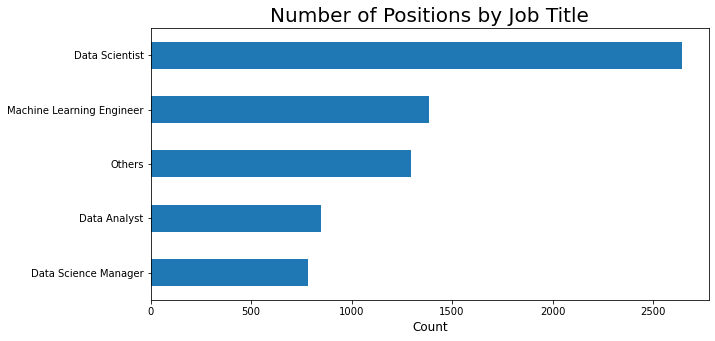

In [10]:
title = data.groupby(['position']).count().sort_values('company')

title['company'].plot(kind='barh',figsize = (10,5))
plt.xlabel('Count', size = 12)
plt.ylabel('')
plt.yticks(size = 10)
plt.xticks(size = 10)
plt.title('Number of Positions by Job Title', size = 20)
plt.show()


### Positions by Companies <a id='company'></a>

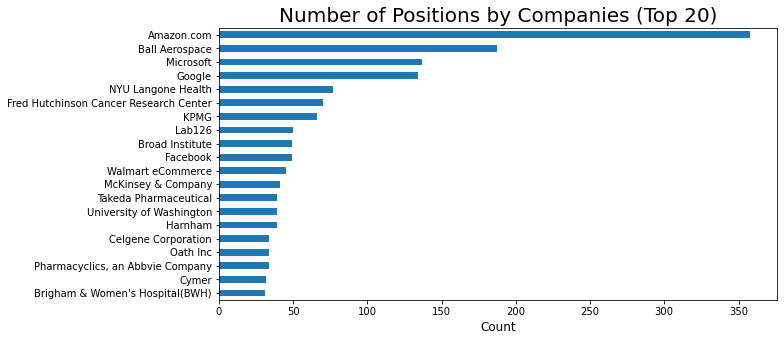

In [11]:
company = df.groupby(['company']).count().sort_values('position').tail(20)

company['position'].plot(kind='barh',figsize = (10,5))
plt.xlabel('Count', size = 12)
plt.ylabel('')
plt.yticks(size = 10)
plt.xticks(size = 10)
plt.title('Number of Positions by Companies (Top 20)', size = 20)
plt.show()

From the chart, we can see that Amazon.com hire the most candidate, follow by Ball Aerospace, Microsoft and Google. 

### Positions by Cities <a id='city'></a>

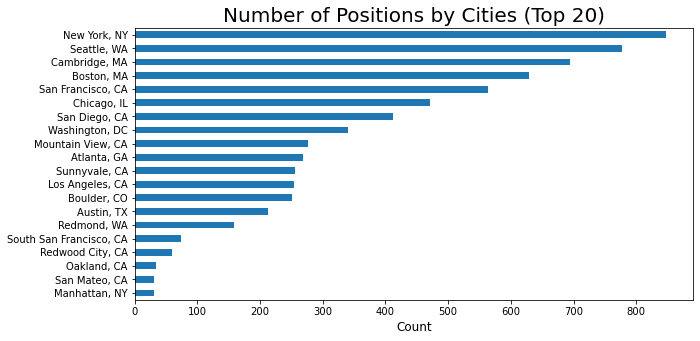

In [12]:
city = df.groupby(['location']).count().sort_values('position').tail(20)

city['position'].plot(kind='barh',figsize = (10,5))
plt.xlabel('Count', size = 12)
plt.ylabel('')
plt.yticks(size = 10)
plt.xticks(size = 10)
plt.title('Number of Positions by Cities (Top 20)', size = 20)
plt.show()

It appears that the top 5 cities that hire the most data science related job are New York, Seattle, Cambridge, Boston, and San Francisco. It makes sense since those cities are the technology hub of the country. 

### Positions by States <a id='state'></a>

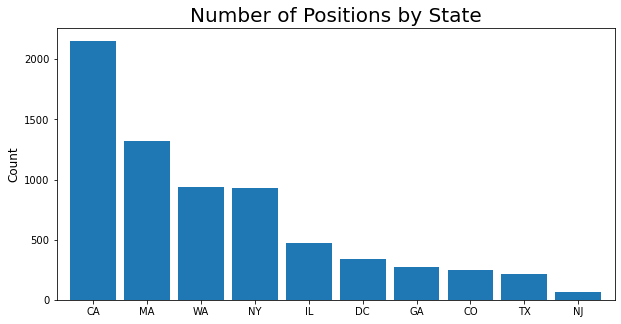

In [13]:
state = df.groupby('state').count().sort_values('position',ascending = False)

state['position'].plot(kind = 'bar',figsize = (10,5) ,width = 0.85)
plt.xlabel('')
plt.ylabel('Count',size = 12)
plt.title('Number of Positions by State', size = 20)
plt.yticks(size = 10)
plt.xticks(size = 10, rotation = 720)
plt.show()

Even though the city with the highest number of positions is New York, the highest number of position by state is California, follows by Massachusetts and Washington. 

### Position by State and Job Title <a id='statetitle'></a>

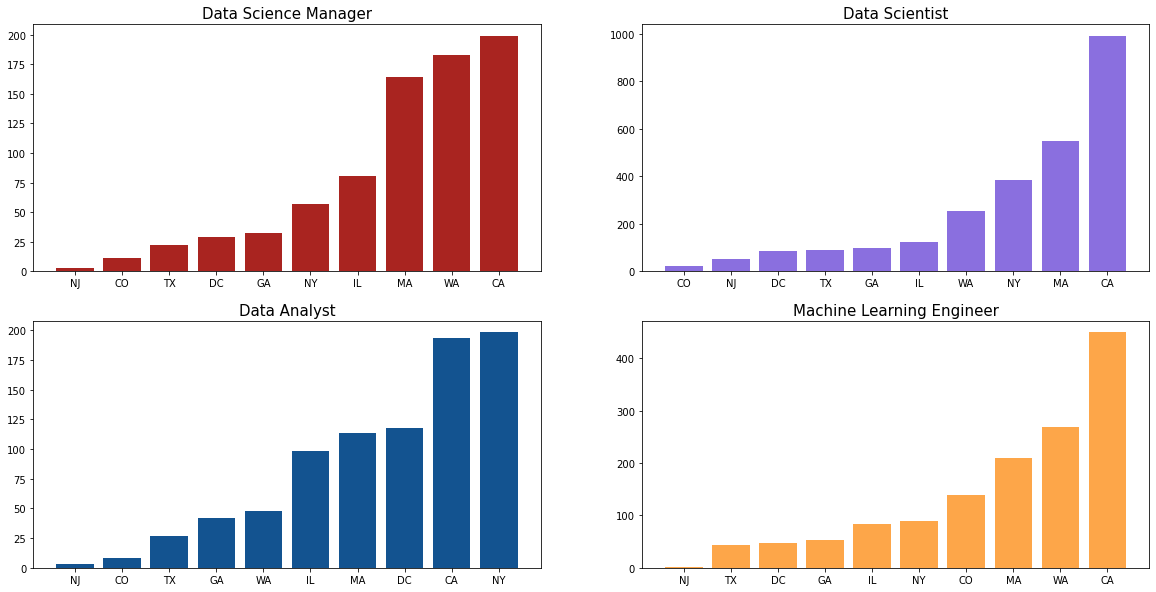

In [14]:
data = data[data['position'] != 'Others']
i = 1
color = ['#A92420','#8A6FDF','#135390','#FDA649']
fig = plt.figure(figsize=(20,10))
for position in data.position.unique():
    x = data[data['position']== str(position)].groupby(['state']).count().sort_values('company')
    plt.subplot(2, 2, i)
    i += 1
    plt.bar(x.index,x['company'], color = color[i-2])
    plt.xlabel('')
    plt.xticks(size = 10)
    plt.title(str(position), size = 15)
plt.show()

- For Data Science Manager, Data Scientist and Machine Learning Engineer, California is the state that hire the most position
- For Data Analyst, it seems that New York hires the most position, follow closely by California

## Text Analysis <a id='textanalysis'></a>

In this section, I will focus on the Job Description column of the data. By using libraries like **re, wordcloud, matplotlib**, I hope to gain further insights on the requirements for the field of data science. I will try to answer the following questions:
- What are the companies looking for when hiring?
- How many years of experience do they required?
- What level of education do the companies prefer?

In [15]:
# Example of a description value
df.description.values[0][0:int(len(df.description.values[0])/2)]

"Development Director\nALS Therapy Development Institute has an immediate opening for Development Directors. Reporting directly to the Senior Development Director, the Development Director at ALS TDI is a senior fundraising position working to identifying potential prospects and cultivating solicitation strategies and in closing asks with donors including individuals and corporations by building networks via events, generating awareness of ALS TDI; outreach including attending and speaking at events as well as personally cultivates relationships with patients, prospects and donors. This position will be responsible for generating and managing a portfolio of at least two million to five million dollars per year. This position will be located in Atlanta, GA.\n\nRequirements:\nBachelor's Degree requiredMinimum 6-8 years' experience in fundraising and business developmentSuccessful track recording in fundraising with major donors or scientific sales preferredDemonstrated ability to work in

### Text Cleaning and Prepration <a id='textclean'></a>

In [16]:
# Combine the desciptions by the job tilte
data = data.groupby('position').agg(lambda col: ' '.join(col))
data = data[['description']]

In [17]:
# Create a function to clean text data
def clean_text(text):
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text).lower() #remove punctutations
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n',' ',text)
    return text

In [18]:
# Clean the text data and remove the job title 'Others'
clean = lambda x :clean_text(x)
df_clean = pd.DataFrame(data.description.apply(clean))
df_clean = df_clean[df_clean.index != 'Others'].copy()

In [19]:
# Lemmentize the text data to improve analysis
lemmer = WordNetLemmatizer()
df_clean['description'] = df_clean.description.apply(lambda x: word_tokenize(x))
df_clean['description'] = df_clean.description.apply(lambda x : [lemmer.lemmatize(y) for y in x])
df_clean['description'] = df_clean.description.apply(lambda x: ' '.join(x))

In [20]:
# Add words that frequently appear in the descriptions but carry no value to the list of stop words
from sklearn.feature_extraction import text
extra_stopword = ['data','experience','work','team','will','skill','year','skills']
stop_words = text.ENGLISH_STOP_WORDS.union(extra_stopword)

### Word Cloud <a id='wordcloud'></a>

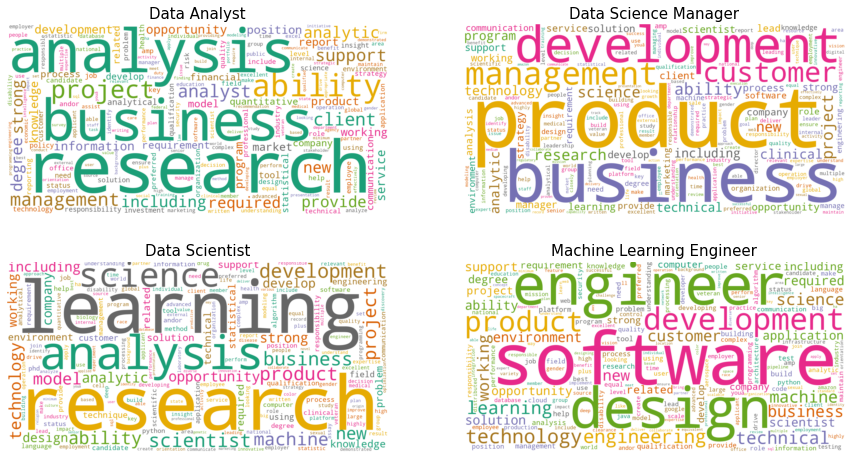

In [21]:
from wordcloud import WordCloud

wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
             random_state=42, collocations = False, width=1600, height=800)
i = 0
fig = plt.figure(figsize=(15,8))
for x in df_clean.description.index:
    wc.generate(df_clean.description[str(x)])
    
    i += 1
    fig.add_subplot(2, 2, i)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(str(x), size = 15)
plt.show()

Here are my interpretations from looking at the WordCloud:
- Data Analyst will be doing **research**, **analysis** and **provide** insights to facilitate better **business** decision.
- Data Science Manager will be in charge of **developing** **product** to help **business** serve its **customer** better.
- Data Scientist will be doing **research**, implementing **machine learning** and building **model** to come up with business solution.
- Machine Learning Engineer will **design** and **develop** **software** for business or customer. 

### Year of Experience Required <a id='experience'></a>

In the following section, I will utilize regular expression to search and locate text strings with in a document.

*Note: I'm still a novice with regex so any recommendation on how to improve my matches will be very much appreciated!*

In [22]:
text = df.description.values

In [23]:
# Print out the first 5 examples of matches
limit = 0
for t in text:
    for sentance in t.split('\n'):
        if 'experience' in sentance:
            year = re.findall("\d{1,2}\+? year", sentance)
            if len(year)==1:
                print(year[0])
                print(sentance)
                print("*"*20)
                limit +=1
    if limit >= 5:
        break

8 year
Bachelor's Degree requiredMinimum 6-8 years' experience in fundraising and business developmentSuccessful track recording in fundraising with major donors or scientific sales preferredDemonstrated ability to work independently and make progress on several prospects/projects at the same time.Excellent English oral, written and presentation skillsStrong leadership and management skills, as well as the ability to forge strong interpersonal relationshipsAbility to travelExcellent computer skills including use of word processing, spreadsheet, database, presentation and prospect management software operating off a PC-based system including Salesforce.
********************
5+ year
5+ years experience, with varying datasets and experience with Computational Biology/Statistics/Physics, Mathematics, Computer Science, Algorithms/Incorporate Learning, etc.
********************
10+ year
10+ years of experience in Data Architecture in a professional services environment is highly preferred
**

In [24]:
# Compile the year value found into a list
experience_req = []
for t in text:
    for sentance in t.split('\n'):
        if 'experience' in sentance:
            year = re.findall("\d{1,2}\+? year", sentance)
            if len(year)==1:
                num = year[0].split(' ')
                experience_req.append(num[0])

In [25]:
# Remove the '+' sign after year value
for n,i in enumerate(experience_req):
    if "+" in i:
        experience_req[n] = re.sub(r'\+','',i)
experience_req = [int(item) for item in experience_req]

In [26]:
# Remove outliers
for n,i in enumerate(experience_req):
    if i >= 20:
        experience_req.pop(n)

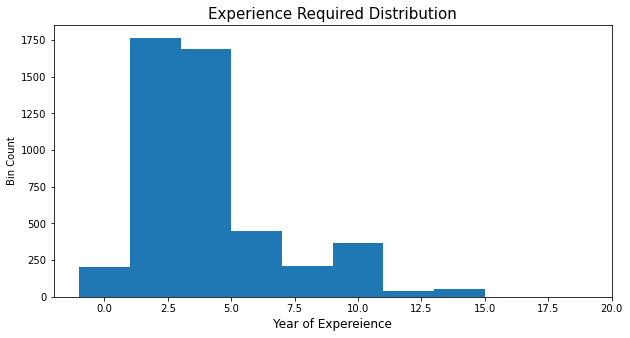

The average year of experience required is 4.67 years


In [27]:
plt.figure(figsize = (10,5))
plt.hist(experience_req,bins = list(range(0,21,2)), align = 'left')
plt.title('Experience Required Distribution', size = 15)
plt.ylabel('Bin Count')
plt.xlabel('Year of Expereience', size = 12)
plt.show()
print(f'The average year of experience required is {round(np.mean(experience_req),2)} years')

### Skill Requirement <a id='skill'></a>

In [28]:
# Create a regex search function
def count_text(patt,text):
    pattern = re.compile(patt)
    count = 0
    for t in text:
        if pattern.search(t):
            count+=1
    return count

In [29]:
# Create a data frame with skills name and regex pattern to search with
skills = ['R','Python','Hadoop','SQL','Tableau','TensorFlow','Agile','Power BI','SSaS','Algorithm','Java','Visualization']

skill_patt = ['\WR\W+\s*','(?i)\WPython\W','(?i)\WHadoop\W?','(?i)SQL\w*','(?i)\WTableau\W?',
              "(?i)\WTensorFlow\W?","(?i)\WAgile\W?","(?i)\WPower\s?BI\W?",
             "(?i)\WSSAS\W?","(?i)\WAlgorithms?\W?",'(?i)Java\w*','(?i)\WVisualization\W?']

skill_df =pd.DataFrame(
    {"skill": skills,
     "regex_pattern":skill_patt})

In [30]:
# Iterate through the list of skill using the search function created
i = []
for x in skill_df['regex_pattern']:
    i.append(count_text(x,text))
skill_df['count'] = i
skill_df['ptg'] = round(skill_df['count']/len(text),2)
skill_df

,skill,regex_pattern,count,ptg
0,R,\WR\W+\s*,2183,0.31
1,Python,(?i)\WPython\W,2822,0.41
2,Hadoop,(?i)\WHadoop\W?,923,0.13
3,SQL,(?i)SQL\w*,1924,0.28
4,Tableau,(?i)\WTableau\W?,492,0.07
5,TensorFlow,(?i)\WTensorFlow\W?,406,0.06
6,Agile,(?i)\WAgile\W?,698,0.10
7,Power BI,(?i)\WPower\s?BI\W?,66,0.01
8,SSaS,(?i)\WSSAS\W?,9,0.00
9,Algorithm,(?i)\WAlgorithms?\W?,1703,0.24


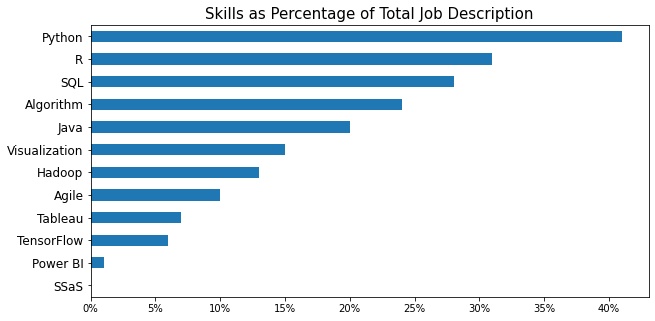

In [31]:
x = skill_df.sort_values(by = 'ptg')
ax =x['ptg'].plot(kind = "barh",figsize = (10,5))
ax.set_title('Skills as Percentage of Total Job Description', size = 15)
ax.set_yticklabels(x['skill'], size = 12)
ax.set_xticklabels(['{:.0%}'.format(x) for x in ax.get_xticks()])
plt.show()

### Degree Requirement <a id='degree'></a>

In [32]:
# Define regex pattern and seach for PhD
pattern = re.compile('(?i)\WPh.?D\W')
pattern2 = re.compile('(?i)\WDoctorate\W')
count = 0
for t in text:
    if pattern.search(t):
        count +=1
    elif pattern2.search(t):
        count +=1
degree = {"PhD": count}

In [33]:
# Define regex pattern and seach for Master 
pattern = re.compile("(?i)\WMasters?'?s?\W")
pattern2 = re.compile('(?i)\WM.?S\W')
count = 0
for t in text:
    if pattern.search(t):
        count +=1
    elif pattern2.search(t):
        count +=1
degree.update({"Master":count})

In [34]:
degree = pd.DataFrame.from_dict(degree,orient='index',
                       columns=[ 'count'])
degree['ptg'] = degree['count']/len(text)

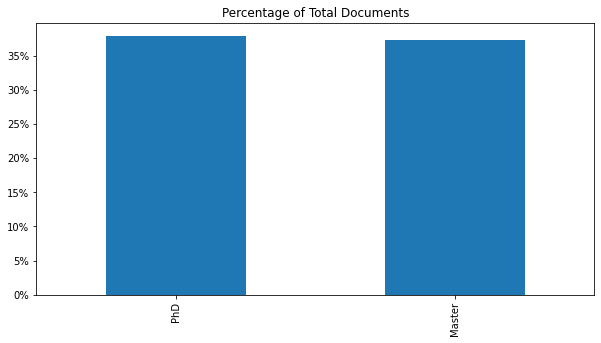

In [35]:
ax =degree['ptg'].plot(kind = "bar", figsize =(10,5))
ax.set_title('Percentage of Total Documents')
ax.set_xticklabels(degree.index)
ax.set_yticklabels(['{:.0%}'.format(x) for x in ax.get_yticks()])
plt.show()

## Conclution <a id='conclution'></a>

This project provided me with valuable insights on what the companies are looking for in a data science candidate. There are a few things I wish to improve especially in the text analysis portion. I hope to learn more on how to better use regular expression so I can get a better precision on my matches.

As a senior looking to break into data science and pursue a career as a Data Analyst, this are the key takeaways:
- To improve my chances, I should be looking into jobs in NY, CA, MA, and WA. Especially in the cities of New York, Seattle, Boston, and San Fran.
- Since I already have some knowledge of Python, R and SQL, I should continue to improve these skills find a way to showcase my knowledge.
- I should really consider going for a Master's degree since a lot of job prefer a candidate with one.
- The average work experience required is 4-5 years, so I need to find an entry level analyst and do more project to satisfy this requirement.

Thank you for going through my notebook! I hope you found some of these findings useful or at least somewhat interesting.

Feel free to connect with me through my https://www.linkedin.com/in/vidya-sagar-mekapothula-5382a8a1/ or send me an email at vidyasagar.mekapothula@gmail.com 